# Term Project

In [1]:
import glob
import random
import numpy as np
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.util.shape import view_as_blocks
from skimage import io, transform
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
import warnings
warnings.filterwarnings('ignore')

2022-12-08 14:05:57.785466: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 14:05:57.893083: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-08 14:05:57.893100: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-08 14:05:58.813521: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-0

### Chess Positions Dataset

I found a dataset which contains 100000 images of a randomly generated chess positions on Kaggle:

https://www.kaggle.com/datasets/koryakinp/chess-positions

The goal of this project will be to create a model which will generate the FEN description based on the image. A FEN record defines a particular game position, all in one text line and using only the ASCII character set. 

For example, the chess starting position has the following FEN description:

rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1

#### Forsyth–Edwards Notation (FEN) from Wikipedia:

A FEN record contains six fields, each separated by a space. The fields are as follows:

1. Piece placement data: Each rank is described, starting with rank 8 and ending with rank 1, with a "/" between each one; within each rank, the contents of the squares are described in order from the a-file to the h-file. Each piece is identified by a single letter taken from the standard English names in algebraic notation (pawn = "P", knight = "N", bishop = "B", rook = "R", queen = "Q" and king = "K"). White pieces are designated using uppercase letters ("PNBRQK"), while black pieces use lowercase letters ("pnbrqk"). A set of one or more consecutive empty squares within a rank is denoted by a digit from "1" to "8", corresponding to the number of squares.
2. Active color: "w" means that White is to move; "b" means that Black is to move.
3. Castling availability: If neither side has the ability to castle, this field uses the character "-". Otherwise, this field contains one or more letters: "K" if White can castle kingside, "Q" if White can castle queenside, "k" if Black can castle kingside, and "q" if Black can castle queenside. A situation that temporarily prevents castling does not prevent the use of this notation.
4. En passant target square: This is a square over which a pawn has just passed while moving two squares; it is given in algebraic notation. If there is no en passant target square, this field uses the character "-". This is recorded regardless of whether there is a pawn in position to capture en passant. An updated version of the spec has since made it so the target square is only recorded if a legal en passant move is possible but the old version of the standard is the one most commonly used.
5. Halfmove clock: The number of halfmoves since the last capture or pawn advance, used for the fifty-move rule.
6. Fullmove number: The number of the full moves. It starts at 1 and is incremented after Black's move.

For this project, I will only be able to get the first bit of the FEN description, the piece placement data. This is because there is no way to know whose move it is, or how many moves have been played, based solely on an image of a chess position.

#### Reading in the dataset

After defining the global path to the the data, we shuffle it and select our training and test subsets.

In [2]:
train_path = glob.glob("dataset/train/*.jpeg")
test_path = glob.glob("dataset/test/*.jpeg")

random.shuffle(train_path)
random.shuffle(test_path)

train_size = 5000
test_size = 5000
train = train_path[:train_size]
test = test_path[:test_size]

piece_symbols = 'prbnkqPRBNKQ'

#### Labeled Data

Since the data is labeled by having the filename of each image corresponding to its FEN description, we can write a function that gets the FEN string from the filename.

In [3]:
def get_FEN_string(filename):
    fen_string = filename.replace('.jpeg', '').split('/')[-1]
    return fen_string

In [4]:
print(get_FEN_string(train[0]))
print(get_FEN_string(train[1]))
print(get_FEN_string(train[2]))

8-N7-7R-1K6-1P5p-7k-8-5N2
1b3N1k-7p-5n2-3bN1Np-8-2pK4-2N2n2-4B3
8-5b2-4b3-2K2k2-8-3p4-8-5q2


We can see that instead of using forward slashes, the dataset has stored the FEN strings with dashes seperating each rank. This was most likely done for filename compatibility.

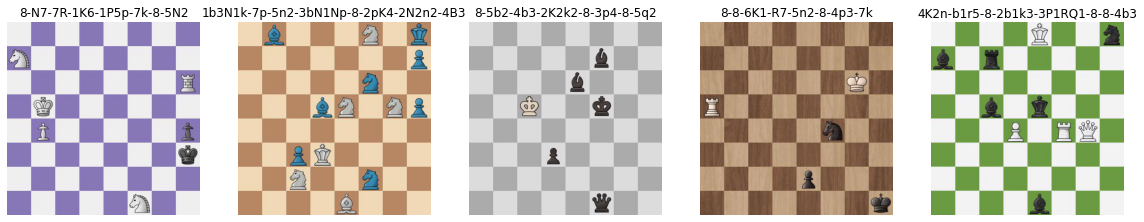

In [5]:
f, axarr = plt.subplots(1,5, figsize=(20, 30))

for i in range(0,5):
    axarr[i].set_title(get_FEN_string(train[i]))
    axarr[i].imshow(mpimg.imread(train[i]))
    axarr[i].axis('off')